# Permutation Importance
    Model-Agnostic Global Feature Importance
## Objective

This notebook introduces permutation importance as a robust, model-agnostic approach to global interpretability. It focuses on:

- Measuring true performance impact of features

- Comparing importance across models

- Detecting reliance vs spurious correlations

- Identifying leakage and unstable features

It answers:

    Which features does the trained model truly depend on for predictive performance?

## Why Permutation Importance?

Model-based importance answers:

> What did the model use internally?

 Permutation importance answers:

> What actually matters for prediction accuracy?

It is:

- Model-agnostic

- Metric-aware

- Directly tied to business performance

## Conceptual Overview

For each feature:

Shuffle its values (breaking its relationship with target)

- Measure performance degradation

- Larger drop ⇒ more important

Importance = **performance loss**, not coefficient size

## Import and Dataset

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance


In [55]:
DATA_PATH = '''D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv'''

df = pd.read_csv(DATA_PATH)

X = df.drop(columns=["default", "customer_id"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=2010
)


# Train Reference Models
## Logistic Regression Pipeline

In [21]:
logit = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logit.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## Random Forest Model

In [24]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=300,
                       random_state=42)

## Permutation Importance (Logistic Regression)

In [27]:
perm_logit = permutation_importance(
    logit,
    X_test,
    y_test,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42
)


### Visualize Importance

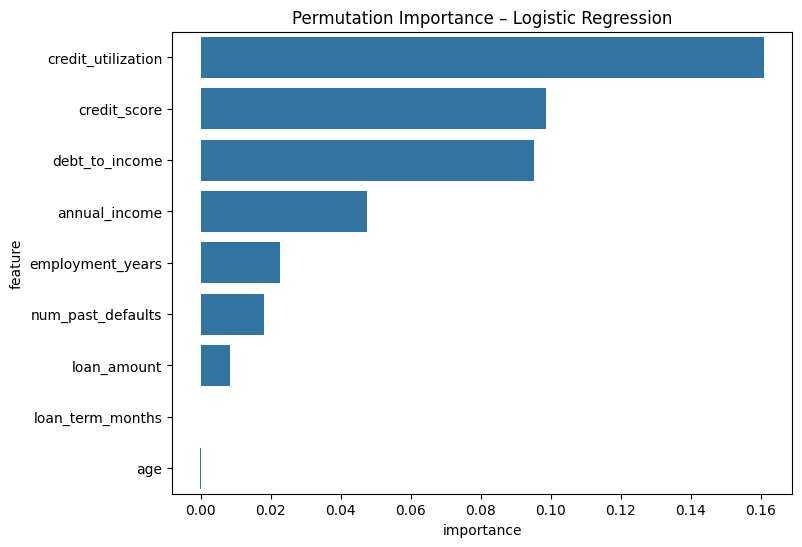

In [30]:
logit_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": perm_logit.importances_mean,
    "std": perm_logit.importances_std
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    data=logit_importance.head(10),
    x="importance",
    y="feature"
)
plt.title("Permutation Importance – Logistic Regression")
plt.show()


## Permutation Importance (Random Forest)

In [33]:
perm_rf = permutation_importance(
    rf,
    X_test,
    y_test,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42
)


### Visualize Importance

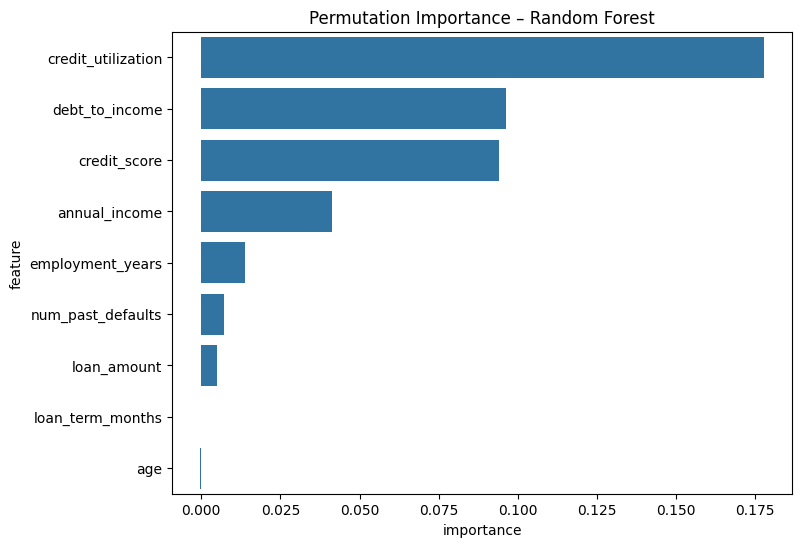

In [36]:
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": perm_rf.importances_mean,
    "std": perm_rf.importances_std
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    data=rf_importance.head(10),
    x="importance",
    y="feature"
)
plt.title("Permutation Importance – Random Forest")
plt.show()


# Compare Across Models

In [40]:
comparison = logit_importance.merge(
    rf_importance,
    on="feature",
    suffixes=("_logit", "_rf")
)

comparison.sort_values("importance_rf", ascending=False)


,feature,importance_logit,std_logit,importance_rf,std_rf
0,credit_utilization,0.160912,0.008765,0.177847,0.010339
2,debt_to_income,0.095291,0.005650,0.096396,0.006245
1,credit_score,0.098577,0.004330,0.094128,0.005182
3,annual_income,0.047627,0.003213,0.041384,0.002590
4,employment_years,0.022779,0.002947,0.013884,0.001488
5,num_past_defaults,0.018086,0.002568,0.007173,0.000983
6,loan_amount,0.008328,0.001302,0.005108,0.000820
7,loan_term_months,0.000007,0.000020,-0.000081,0.000092
8,age,-0.000074,0.000170,-0.000267,0.000246


📌 Stable features across models → trustworthy

📌 Model-specific features → interaction effects


## Detect Leakage Candidates

In [43]:
logit_importance.query("importance > 0.05")


,feature,importance,std
2,credit_utilization,0.160912,0.008765
8,credit_score,0.098577,0.004330
3,debt_to_income,0.095291,0.005650


- Unexpectedly dominant features require investigation.

##  Limitations of Permutation Importance

❌ Underestimates importance of:

- Correlated features

- Redundant variables

❌ Computationally expensive

❌ Sensitive to test-set noise

##  Best Practices

- ✔ Always use a held-out test set
- ✔ Repeat permutations
- ✔ Compare across models
- ✔ Pair with SHAP for local insight
- ✔ Investigate large importance spikes

## Summary Table

| Property            | Permutation Importance |
| ------------------- | ---------------------- |
| Model-agnostic      | ✔                      |
| Performance-based   | ✔                      |
| Detects leakage     | ✔                      |
| Handles correlation | ❌                      |
| Local explanations  | ❌                      |


## Key Takeaways

- Permutation importance measures real impact

- Model-based importance can be misleading

- Stability across models increases trust

- Use for governance and audits

- Never interpret in isolation

##  Next Notebook
08_Interpretability_and_Explainability/

├── 01_global_interpretability/

│   └── [03_partial_dependence_plots.ipynb](03_partial_dependence_plots.ipynb)